In [1]:
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import sys  
sys.path.insert(1, '../../backend/')
from tsne import compute_tsne_series
from utils import normalizeEmbedding

In [2]:
# this function is copied from Böhm et al. (2022)
# https://github.com/berenslab/ne-spectrum/blob/56e7204710258d541fb716033d3542a4fca2705e/jnb_msc/generator/gauss_line.py#L72
def gauss_clusters(
    n_clusters=10, dim=50, pts_cluster=100, random_state=None, cov=1, stepsize=6,
):

    if random_state is None:
        rng = np.random.RandomState()
    else:
        rng = random_state

    n = n_clusters * pts_cluster

    s = stepsize / np.sqrt(dim)
    means = np.linspace(np.zeros(dim), n_clusters * s, num=n_clusters, endpoint=False)
    #cshift_mask = np.zeros(n_clusters, dtype=bool)
    #cshift_mask[15] = True
    cov = np.eye(dim) * cov

    clusters = np.array(
        [rng.multivariate_normal(m, cov, size=(pts_cluster)) for m in means]
    )

    X = np.reshape(clusters, (-1, dim))

    y = np.repeat(np.arange(n_clusters), pts_cluster)
    return X, y

In [3]:
data, labels = gauss_clusters()
print(data.shape)

(1000, 50)


In [4]:
adata = anndata.AnnData(X=data, obs={"labels": labels.astype(int)})
adata.obs['labels_cat'] = adata.obs['labels'].astype('category')

# PCA

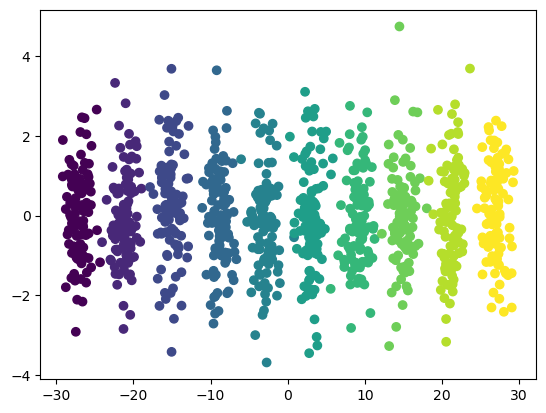

In [5]:
sc.pp.pca(adata, n_comps=2, zero_center=True)
plt.scatter(adata.obsm['X_pca'][:,0], adata.obsm['X_pca'][:,1], c=labels)

# UMAP

In [6]:
sc.pp.neighbors(adata, n_neighbors=30, metric="euclidean")
sc.tl.umap(adata, min_dist=0.2, init_pos="X_pca")

/home/eheiter/Projects/zoomer/backend/backend_env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/eheiter/Projects/zoomer/backend/backend_env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/eheiter/Projects/zoomer/backend/ba

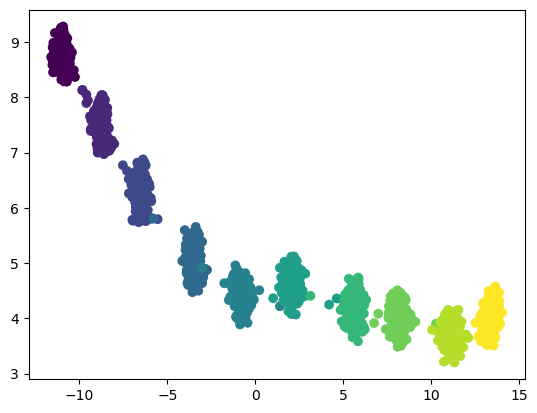

In [7]:
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], c=labels)

In [8]:
%%capture
tsne_embs = compute_tsne_series(adata.X, max_exaggeration=5, 
                                 fpath_prefix="/home/eheiter/Projects/zoomer/data/gauss_line/tSNE", 
                                 hd_metric="euclidean", init=adata.obsm["X_pca"])

# Store embeddings in anndata

In [9]:
# tSNE
for name, embedding in tsne_embs.items():
    adata.obsm[name] = normalizeEmbedding(embedding)
    adata.uns[name] = {}

In [10]:
adata.obsm["PCA_0"] = normalizeEmbedding(adata.obsm["X_pca"][:, 0:2])
adata.obsm["UMAP_0"] = normalizeEmbedding(adata.obsm["X_umap"])
adata.uns["UMAP_0"] = {}
adata.uns["PCA_0"] = {}
adata.uns["methods"] = {
    "UMAP": 1,
    "PCA": 1,
    "tSNE": len(tsne_embs),
}

In [11]:
if "X_pca" in adata.obsm_keys():
    del adata.obsm["X_pca"]
if "X_umap" in adata.obsm_keys():
    del adata.obsm["X_umap"]
adata.write(filename="./gauss_line.h5ad", compression="gzip")